In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Lada.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Kalina,Seri_Samara,Seri_VAZ,Seri_Vega,Model_1.3,Model_1.5,Model_1.6,Model_2105.0,Model_2107.0,Yakıt Tipi_Benzin,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz
0,102000,-0.909091,-0.694444,-0.293269,0.898876,NaN,NaN,0,0,0,1,0,1,0,0,0,1,0,1
1,75000,-1.636364,-0.944444,-0.293269,-0.333828,NaN,NaN,0,1,0,0,0,1,0,0,0,0,1,1
2,130000,-1.000000,-0.694444,-0.293269,-0.119850,NaN,NaN,0,0,0,1,0,1,0,0,0,0,1,1
3,186000,-0.363636,-0.611111,0.173077,0.037453,8.0,0.0,1,0,0,0,0,0,1,0,0,0,1,1
4,80000,-1.727273,-0.944444,-0.293269,2.621723,NaN,NaN,0,1,0,0,0,1,0,0,0,0,1,1


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_8076\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,23711.58985,7.811349e+08,27948.790465,22610.721436


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:05:54,278] A new study created in memory with name: no-name-dfdf77ee-5f28-4de3-9962-43c3ec3aa4f0
[I 2023-05-23 21:05:54,370] Trial 1 finished with value: 126353.73079028969 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.2900395709856543, 'max_depth': 9, 'min_child_weight': 291}. Best is trial 1 with value: 126353.73079028969.
[I 2023-05-23 21:05:54,381] Trial 3 finished with value: 124863.07826747662 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0014422373557906683, 'max_depth': 8, 'min_child_weight': 57}. Best is trial 3 with value: 124863.07826747662.
[I 2023-05-23 21:05:54,383] Trial 6 finished with value: 124598.60517784338 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.0016941072660897761, 'max_depth': 15, 'min_child_weight': 73}. Best is trial 6 with value: 124598.60517784338.
[I 2023-05-23 21:05:54,386] Trial 0 finished with value: 126109.97105731604 and parameters: 

[I 2023-05-23 21:05:55,177] Trial 30 finished with value: 28209.762726754267 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.2586234166743723, 'max_depth': 6, 'min_child_weight': 27}. Best is trial 30 with value: 28209.762726754267.
[I 2023-05-23 21:05:55,224] Trial 29 finished with value: 27038.1826184639 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.24198446785564875, 'max_depth': 3, 'min_child_weight': 24}. Best is trial 29 with value: 27038.1826184639.
[I 2023-05-23 21:05:55,313] Trial 32 finished with value: 24280.931470979544 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.48588635796631957, 'max_depth': 4, 'min_child_weight': 31}. Best is trial 32 with value: 24280.931470979544.
[I 2023-05-23 21:05:55,313] Trial 33 finished with value: 23993.40405903536 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.43544533856849976, 'max_depth': 4, 'min_child_weight': 

[I 2023-05-23 21:05:56,276] Trial 58 finished with value: 26152.752639619262 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.289469564847064, 'max_depth': 7, 'min_child_weight': 37}. Best is trial 33 with value: 23993.40405903536.
[I 2023-05-23 21:05:56,362] Trial 61 finished with value: 26077.144038443927 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.30649712358078013, 'max_depth': 3, 'min_child_weight': 35}. Best is trial 33 with value: 23993.40405903536.
[I 2023-05-23 21:05:56,384] Trial 63 finished with value: 126353.73079028969 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.2945234281562381, 'max_depth': 3, 'min_child_weight': 197}. Best is trial 33 with value: 23993.40405903536.
[I 2023-05-23 21:05:56,392] Trial 62 finished with value: 25089.34801379174 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.30511724145545543, 'max_depth': 3, 'min_child_weight': 

[I 2023-05-23 21:05:57,834] Trial 93 finished with value: 24119.693766435987 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.36070766950800637, 'max_depth': 6, 'min_child_weight': 9}. Best is trial 88 with value: 22169.021326097027.
[I 2023-05-23 21:05:57,844] Trial 91 finished with value: 24026.641549969525 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.37224874131974584, 'max_depth': 6, 'min_child_weight': 8}. Best is trial 88 with value: 22169.021326097027.
[I 2023-05-23 21:05:57,857] Trial 90 finished with value: 27037.651189643155 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.36463524081915544, 'max_depth': 6, 'min_child_weight': 46}. Best is trial 88 with value: 22169.021326097027.
[I 2023-05-23 21:05:57,881] Trial 92 finished with value: 27304.84549956728 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.3603074339961275, 'max_depth': 6, 'min_child_weight'

[I 2023-05-23 21:05:59,062] Trial 120 finished with value: 22743.895030793974 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.4081730080755167, 'max_depth': 9, 'min_child_weight': 13}. Best is trial 88 with value: 22169.021326097027.
[I 2023-05-23 21:05:59,167] Trial 121 finished with value: 22169.843999923018 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.49629306822606484, 'max_depth': 7, 'min_child_weight': 22}. Best is trial 88 with value: 22169.021326097027.
[I 2023-05-23 21:05:59,182] Trial 122 finished with value: 126353.73079028969 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.48632342138627527, 'max_depth': 7, 'min_child_weight': 158}. Best is trial 88 with value: 22169.021326097027.
[I 2023-05-23 21:05:59,299] Trial 123 finished with value: 23836.332550642255 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.3348874978654309, 'max_depth': 7, 'min_child_

[I 2023-05-23 21:06:00,529] Trial 150 finished with value: 23162.150272482104 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.3134478965274191, 'max_depth': 7, 'min_child_weight': 15}. Best is trial 88 with value: 22169.021326097027.
[I 2023-05-23 21:06:00,562] Trial 151 finished with value: 24394.02552794522 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.30174608800931185, 'max_depth': 10, 'min_child_weight': 15}. Best is trial 88 with value: 22169.021326097027.
[I 2023-05-23 21:06:00,636] Trial 152 finished with value: 21692.075307474843 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.39581493056459804, 'max_depth': 7, 'min_child_weight': 15}. Best is trial 152 with value: 21692.075307474843.
[I 2023-05-23 21:06:00,690] Trial 153 finished with value: 22627.600463046863 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.4049757014078843, 'max_depth': 7, 'min_child_

[I 2023-05-23 21:06:02,173] Trial 180 finished with value: 23187.682817962566 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.391534323639967, 'max_depth': 12, 'min_child_weight': 11}. Best is trial 152 with value: 21692.075307474843.
[I 2023-05-23 21:06:02,186] Trial 181 finished with value: 23348.33479374502 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.3635532232325481, 'max_depth': 12, 'min_child_weight': 9}. Best is trial 152 with value: 21692.075307474843.
[I 2023-05-23 21:06:02,196] Trial 183 finished with value: 126353.73079028969 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.3615679650486642, 'max_depth': 15, 'min_child_weight': 133}. Best is trial 152 with value: 21692.075307474843.
[I 2023-05-23 21:06:02,235] Trial 182 finished with value: 22838.222588589768 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.3621048916280009, 'max_depth': 12, 'min_chil

[I 2023-05-23 21:06:03,868] Trial 210 finished with value: 26335.346092393083 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.28543095340604013, 'max_depth': 6, 'min_child_weight': 9}. Best is trial 152 with value: 21692.075307474843.
[I 2023-05-23 21:06:03,986] Trial 211 finished with value: 25562.91430297596 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.3236116126119338, 'max_depth': 7, 'min_child_weight': 4}. Best is trial 152 with value: 21692.075307474843.
[I 2023-05-23 21:06:04,055] Trial 212 finished with value: 125489.17968049257 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.0008243988533862782, 'max_depth': 7, 'min_child_weight': 7}. Best is trial 152 with value: 21692.075307474843.
[I 2023-05-23 21:06:04,087] Trial 213 finished with value: 26221.048952896836 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.3319477624436957, 'max_depth': 7, 'min_child_

[I 2023-05-23 21:06:05,578] Trial 240 finished with value: 23443.01564933249 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.496193554308727, 'max_depth': 4, 'min_child_weight': 10}. Best is trial 231 with value: 21618.83072412452.
[I 2023-05-23 21:06:05,586] Trial 241 finished with value: 23718.84268154909 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.48575357809888786, 'max_depth': 4, 'min_child_weight': 9}. Best is trial 231 with value: 21618.83072412452.
[I 2023-05-23 21:06:05,772] Trial 242 finished with value: 21653.190865974222 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.4938450467433597, 'max_depth': 4, 'min_child_weight': 7}. Best is trial 231 with value: 21618.83072412452.
[I 2023-05-23 21:06:05,863] Trial 243 finished with value: 21233.37019002291 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.49900785954925186, 'max_depth': 4, 'min_child_weight'

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 21228.4317
Best params:
	colsample_bytree: 0.6
	subsample: 0.6
	learning_rate: 0.49997068125308136
	max_depth: 4
	min_child_weight: 16


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [4,9],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.6],
               'subsample': [0.6],
               'min_child_weight': [16]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 16, 'n_estimators': 500, 'subsample': 0.6}
{'TestDeger': 21786.977026525863, 'MSE': 526049665.61388874, 'RMSE': 22935.772618638526, 'MAE': 18155.349731445312}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.5320078012748765

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.46720888145139783

In [17]:
marka_model = joblib.dump(grid_final_model, "Lada.pkl")

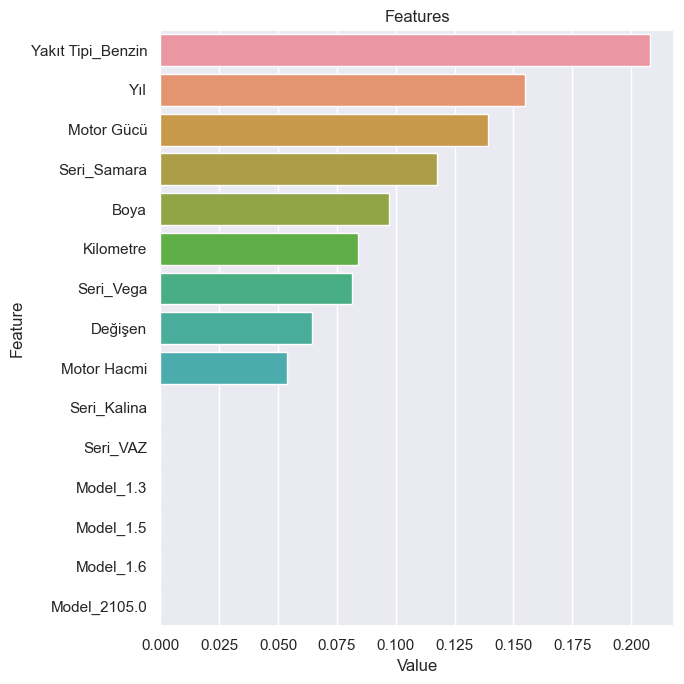

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)